# Recommenders System using Keras Deep Learning

The following is an analysis for using Keras API to create a Deep Learning model for recommenders system.

For this experiment, we will use a reduced form of the Movie-Lens 20 Million data set. The data set has been processed to extract the top 10000 users and top 2000 movies in terms of ratings counts. 

Additionally, the user id and movie ids have been preprocessed such that they exist in sequential numerical order. To be more specific, all user ids exist between 0 to 9999, and all movie ids exist between 0 to 1999. The dataset consist of the following columns:
- `userId`: User ID ranging from 0 to 9999.
- `movieId`: Movie ID ranging from 0 to 1999.
- `rating`: Rating that user gave to movie. Range from 0.5 to 5.0.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
# Load in data
df = pd.read_csv("../data/small_rating.csv")

N = df.userId.max() + 1 # no of users
M = df.movieId.max() + 1 # no of movies

In [4]:
df.head()

,userId,movieId,rating
0,7307,10,4.5
1,7307,68,2.5
2,7307,143,3.5
3,7307,19,5.0
4,7307,85,4.5


In [5]:
# Number of users
N

10000

In [6]:
# Number of items
M

2000

# Train Test Split

As with any recommenders system, we will not expect to have a full complete ratings data set (since not all users will rate all movies, and not all movies will receive ratings from all users). Instead, we only have a partially filled matrix which is sparse in nature.

Thus, all the available data provided is only in terms of provided ratings, from which we can perform train-test split to obtain a set of training data and testing data. By training on the available ratings, we aim to learn the lower dimensional representations of users and items such that the reconstructed ratings are close to the actual ratings. 
- Note that each row of training data comes from a pair of User and Item input, with a label of the Rating. 
- For this analysis, the test dataset will be used for the validation set in the Keras model as shown later.
- Note that we can utilise the reduced dimensionality representations of users and items to obtain the ratings that were not given in the sparse ratings matrix (although there will not be any ground truths to compare them with).

<div align="center">
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSULWEj9qZm6anO_qTV0MSVMNml28H0r0h6VA&usqp=CAU", width = 500>
</div>

In [7]:
# Reproducible train test split
np.random.seed(1)

# Split into train and test
df_shuffled = shuffle(df)
cutoff = int(0.9 * len(df_shuffled))
df_train = df_shuffled.iloc[:cutoff]
df_test = df_shuffled.iloc[cutoff:]

In [8]:
df_train

,userId,movieId,rating
1996526,7460,1153,2.5
1864726,2986,1028,4.5
4206286,2649,173,3.5
4672159,3549,594,1.5
3808932,2688,462,3.0
...,...,...,...
5298654,2383,36,4.0
3559315,6692,90,4.0
2747744,7542,555,2.0
3411346,3419,571,3.0


In [9]:
df_test

,userId,movieId,rating
904377,6119,663,1.0
2489067,4533,742,3.0
4388123,5393,461,3.0
3004970,680,503,4.0
1931382,9937,675,3.0
...,...,...,...
5030793,6374,1366,3.0
491263,6557,335,3.0
3937352,2434,1527,2.5
4686059,2747,17,4.0


# Keras Deep Learning Neural Network Model
For each training data pairing of user and item, we have a training label which represents the rating that the user gave the product. Using Keras, we can set up the `U` and `V` embedding layers (of reduced dimensions) which take in corresponding data inputs in the form of `u` (for user) and `m` (for item). 

By giving `u` as an input to `U` embedding layer, this extracts out the relevant reduced dimension representation of the particular user in the training data pairing. Likewise, the same goes for the `m` input to the `V` embedding layer.

In this context, we flatten the embedding dense representations, and concatenate them such that both users and item representations form an __input layer__. 

After the input layer is created, we can connect them to a hidden Dense layer of units, and thereafter apply a non-linear activation function to connect the hidden layer to an output layer of a single node. In this case, we have 2 key hyper parameters, namely K (latent dimensionality for the embedding representation of user or item) and hidden layer nodes. Be careful not to be confused by both of them.

<div align="center">
    <img src="./img/deep_learning_recommenders_sys.png", width = 500>
</div>

In the following, we obtain the parameters for the experiment such as the hidden/latent dimensionality, the global rating mean for the training data, as well as Keras model parameters.

In [10]:
# Initialize variables
K = 20 # latent dimensionality

# Calculate the mean ratings to be used 
mu = df_train.rating.mean()

# Model parameters
epochs = 10
reg = 0.001 # regularization penalty if required

In the following, we set up the Keras layers as described using the concept of Embedding layers for representation, and obtaining the predicted rating for each pair of user and movie. This is set up such that the model takes in a tuple of 2 inputs `u` and `m`, which are the corresponding user ID and the movie ID.

Since we are dealing with ratings (which is a continuous response variable), we can use Mean Squared Error as the loss function.

As a slight modification to the mathematical equation, we will make the label data (Y) such that it is the actual ratings minus the global ratings means of the training data. This is demonstrated in the following:
$$\hat{rating_{ij}} - rating_{\mu} = U_i \cdot V_j + user\_bias_i + item\_bias_j$$
$$Y = U_i \cdot V_j + user\_bias_i + item\_bias_j$$

In [11]:
# Keras model
# Specifying shape of u and m has downstream implications for the "input_length" for u_embedding and m_embedding.
# Since we are not dealing with text data, the "input_length" is 1.
u = Input(shape = (1,)) 
m = Input(shape = (1,))

# Output Embedding layer of Keras (1, Sequence_length, K (latent/hidden dimensionality for dense representation))
# In the context of matrix factorisation, K is the same for both U and M embedding layers
# sequence_length = 1 since we are dealing with discrete users and items, and not NLP text
u_embedding = Embedding(input_dim = N, output_dim = K, embeddings_regularizer= l2(reg))(u) # Output Embedding layer (Batch_size, 1, K)
m_embedding = Embedding(input_dim = M, output_dim = K, embeddings_regularizer = l2(reg))(m) # Output Embedding layer (Batch_size, 1, K)

# Flattening Embedding layer into 2D
u_embedding = Flatten()(u_embedding) # (batch_size, K)
m_embedding = Flatten()(m_embedding) # (batch_size, K)

# Concatenate the layers 
x = Concatenate()([u_embedding, m_embedding]) # (batch_size, 2K)

# Create 1 hidden layer of 400 hidden units
x = Dense(400)(x)
x = Activation("relu")(x)

# Convert to final prediction of 1 unit
ratings = Dense(1)(x)

model = Model(inputs=[u, m], outputs = ratings)
model.compile(
    # Mse loss function includes regularisation
    loss = "mse", 
    # Optimizer with hyper-parameters
    optimizer = SGD(lr = 0.01, momentum = 0.9),
    # Explicit stating of mse in metrics is returns loss function without regularisation portion
    metrics = ["mse"] 
)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 20)        200000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        40000       input_2[0][0]                    
______________________________________________________________________________________________

With the model summary, we can observe how the inputs `u` and `m` are used to connect with the various embedding layers (`u` for `U` & `u_bias`, `m` for `M` & `m_bias`). Thereafter, we obtain the predicted ratings by performing the necessary dot product with arithmetic operations (accounting for the bias).

As shown in the following, the inputs are based on the pairings of the user ID and movie ID for each rating. The test dataset which we previously obtained is used for the validation data set.

In [14]:
# Train the model
neural_net = model.fit(
    # Training data in tuples (u, m)
    x = [df_train.userId.values, df_train.movieId.values],
    
    # Labels are the deviations from the average ratings
    y = df_train.rating.values - mu,
    epochs= epochs,
    batch_size = 128,
    validation_data = (
        [df_test.userId.values, df_test.movieId.values],
        df_test.rating.values - mu
    )
)

Epoch 1/10
37913/37913 [==============================] - 129s 3ms/step - loss: 0.7314 - mse: 0.6709 - val_loss: 0.7271 - val_mse: 0.6664
Epoch 2/10
37913/37913 [==============================] - 130s 3ms/step - loss: 0.7290 - mse: 0.6687 - val_loss: 0.7281 - val_mse: 0.6689
Epoch 3/10
37913/37913 [==============================] - 128s 3ms/step - loss: 0.7266 - mse: 0.6674 - val_loss: 0.7298 - val_mse: 0.6710
Epoch 4/10
37913/37913 [==============================] - 127s 3ms/step - loss: 0.7254 - mse: 0.6667 - val_loss: 0.7217 - val_mse: 0.6632
Epoch 5/10
37913/37913 [==============================] - 130s 3ms/step - loss: 0.7244 - mse: 0.6658 - val_loss: 0.7232 - val_mse: 0.6648
Epoch 6/10
37913/37913 [==============================] - 148s 4ms/step - loss: 0.7237 - mse: 0.6647 - val_loss: 0.7220 - val_mse: 0.6621
Epoch 7/10
37913/37913 [==============================] - 123s 3ms/step - loss: 0.7239 - mse: 0.6637 - val_loss: 0.7279 - val_mse: 0.6672
Epoch 8/10
37913/37913 [==========

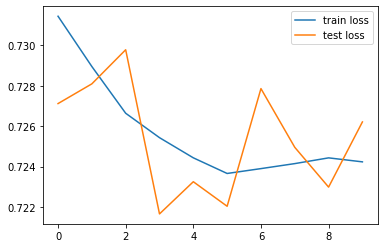

In [18]:
# Plot losses (loss is MSE with regularisation term)
plt.plot(neural_net.history['loss'], label="train loss")
plt.plot(neural_net.history['val_loss'], label="test loss")
plt.legend()
plt.show()

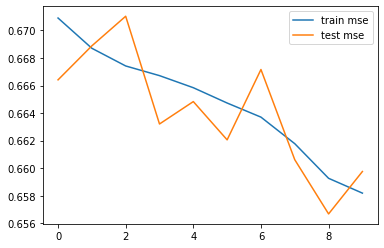

In [19]:
# Plot metric ("mse" metric is MSE without regularisation term)
plt.plot(neural_net.history['mse'], label="train mse")
plt.plot(neural_net.history['val_mse'], label="test mse")
plt.legend()
plt.show()

As depicted, at the end of 10 epochs, the model's loss values are still decreasing and still has room for improvement. At the same time, the Mean Squared Error for both train and test are around 0.658 itself, which is already a drastic improvement compared to the Matrix Factorisation using Embedding layers (that was covered in the previous notebook) which had a MSE of 0.880 after 10 epochs.